# Pharmaceutical Sales prediction across multiple stores


- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Empirical Cumulative Distribution Function](#Empirical-Cumulative-Distribution-Function)
    - [Filtering Missing Values](#Filtering-Missing-Values)
    - [Store data Analysis](#Store-data-Analysis)
    - [Correlation Analysis](#Correlation-Analysis)
    - [Checking for Seasonality](#Checking-for-Seasonality)

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
dfTrain = pd.read_csv('train.csv', low_memory=False, parse_dates=True, index_col='Date')
dfTest = pd.read_csv('test.csv', low_memory=False, parse_dates=True, index_col='Date')
dfStore = pd.read_csv("store.csv", low_memory=False)
print("The Training set's shape is: ", dfTrain.shape)
dfTrain.head()

The Training set's shape is:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [3]:
dfTrain.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [4]:
# add aditional columns to the dataset. 
def dataTuning(df):
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['WeekOfYear'] = df.index.weekofyear
    
    df['SalePerCustomer'] = df['Sales']/df['Customers']
    return df

dfTrain = dataTuning(dfTrain)
dfTrain['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average the users spend about 9.5 dollars but there are days with 0 sales and some with up to approximately 65 dollars

### Empirical Cumulative Distribution Function

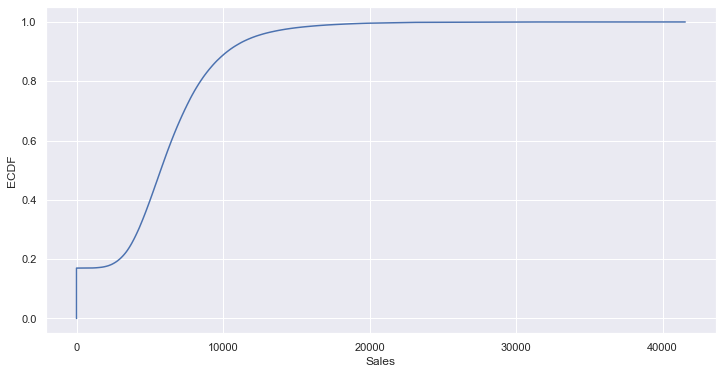

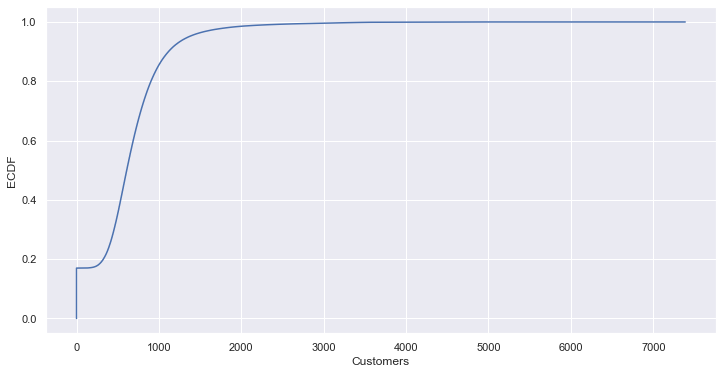

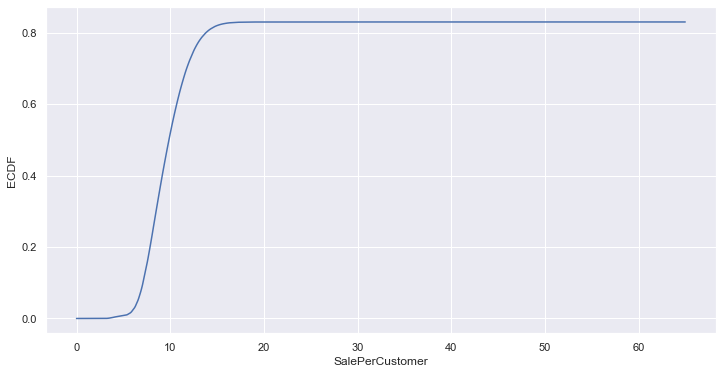

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF

# this fucntion plots the empirical cumulative distribution
def ecdfPlot(series):
    plt.figure(figsize = (12, 6))
    cdf = ECDF(series)
    plt.plot(cdf.x, cdf.y, label="statmodels")
    plt.xlabel(series.name); plt.ylabel('ECDF')
    

ecdfPlot(dfTrain['Sales'])
ecdfPlot(dfTrain['Customers'])
ecdfPlot(dfTrain['SalePerCustomer'])

From the first two graphs we can tell that about 20% of the data has 0 amount os sales and customers.Could this be due to closed stores?

### Filtering Missing Values

In [6]:
# finding the closed stores
dfTrain[(dfTrain.Open == 0) & (dfTrain.Sales == 0)].shape


(172817, 13)

In [7]:
# finding opened stores with zero sales
zeroSales = dfTrain[(dfTrain.Open != 0) & (dfTrain.Sales == 0)]
zeroSales.shape

(54, 13)

We drop the stores with zero no sales and the closed as they make up only a small percentage of our dataset (about 17%)

In [8]:
# dropping the zero sales and closed stores
dfTrain = dfTrain[(dfTrain.Open != 0) & (dfTrain.Sales != 0)]
dfTrain.shape

(844338, 13)

In [9]:
# Showing the store data
print("The store dataset shape is: ", dfStore.shape)
dfStore.head()

The store dataset shape is:  (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
# finding the missing values in the store dataset
dfStore.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [11]:
# starting with the CompetitionDistance column
dfStore[pd.isnull(dfStore.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [12]:
# filling the NaN values in CompetitionDistance col
dfStore.CompetitionDistance.fillna(dfStore.CompetitionDistance.median(), inplace=True)

In [13]:
# replace all the other NaN values with zeros
dfStore.fillna(0, inplace=True)
dfStore.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [14]:
# merge the Store data and the train data
dfTrainStore = pd.merge(dfTrain, dfStore, how='inner', on='Store')
print("The shape of the merged training and store dataset is: ", dfTrainStore.shape)
dfTrainStore.head()

The shape of the merged training and store dataset is:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Store data Analysis

In [15]:
# get the statistics of each Store Type
dfTrainStore.groupby('StoreType').Sales.describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [16]:
# GEt the total sum of Sales and Customers for each store type
dfTrainStore.groupby('StoreType')['Customers', 'Sales'].sum()

c:\users\gkkar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


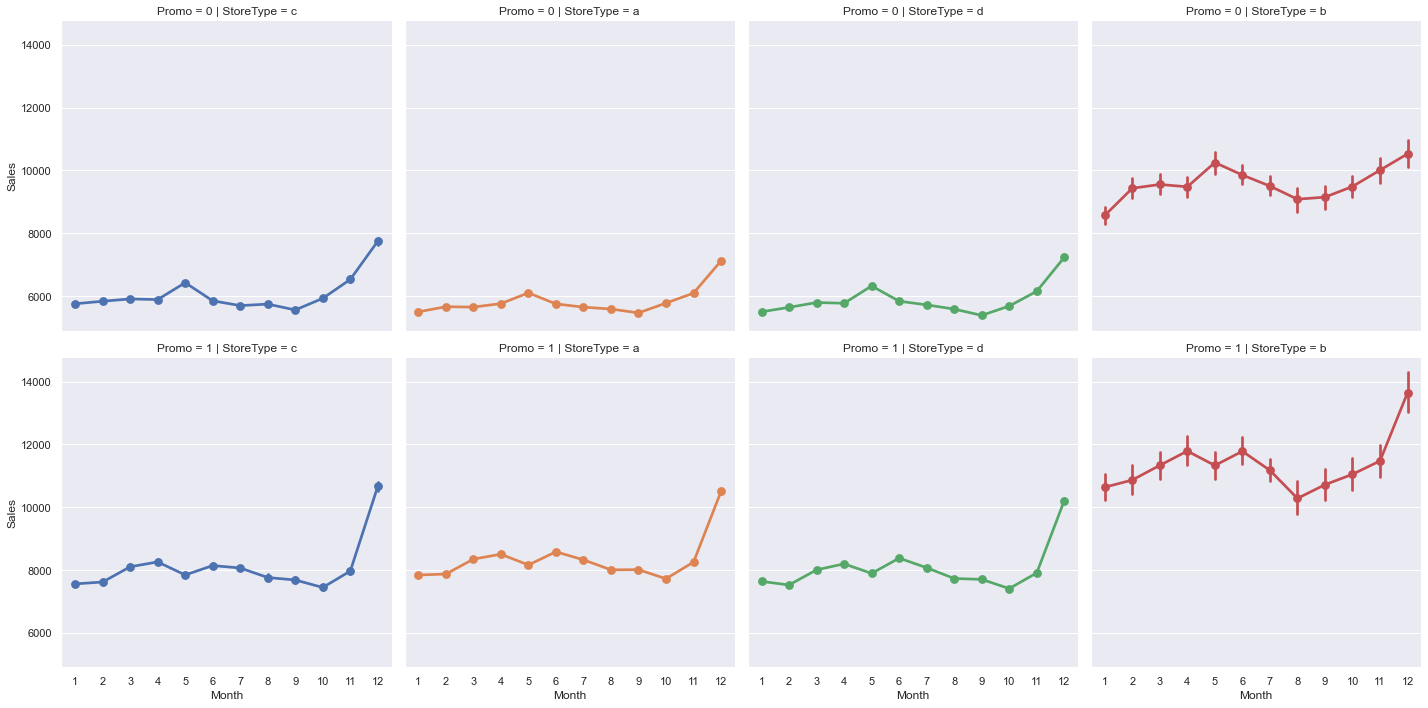

In [17]:
# ploting the Monthly Sales for each store type when with a promo and without one
sns.catplot(x='Month', y='Sales', data=dfTrainStore, kind='point',
            col='StoreType', row='Promo', hue='StoreType')

- There is generally an increase in sales across all store types when there is a promo, with Store Type b having the most Sales through out the year.
- There is an increase in sales around christmas time (Month 12)

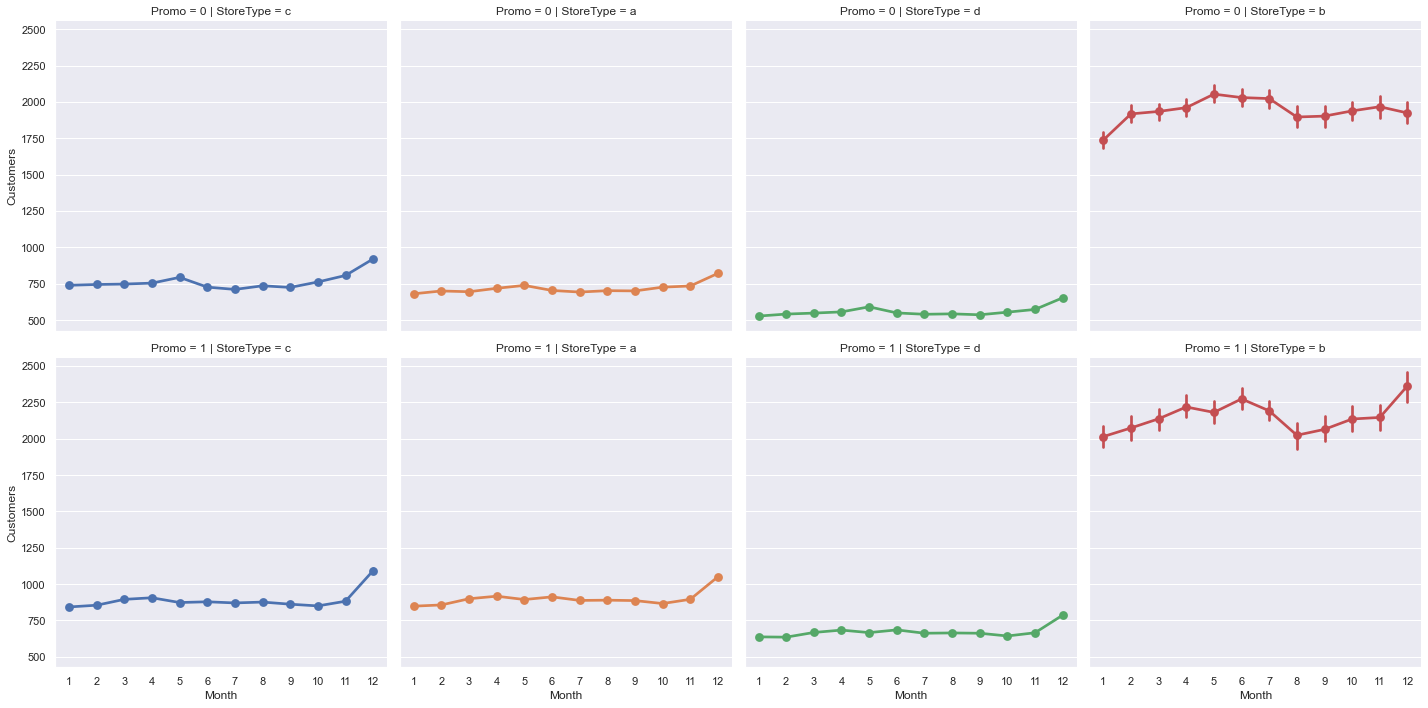

In [18]:
# ploting the montly data of the number Customers when there is a promo and when there isn't one
sns.catplot(y='Customers', x='Month', data=dfTrainStore, kind='point',
            col='StoreType', row='Promo', hue='StoreType')

- There is generally an increase in the number of customers across all store types when there is a promo, with Store Type b having the most Customers through out the year.
- There is an increase in the number of customers around christmas time (Month 12)

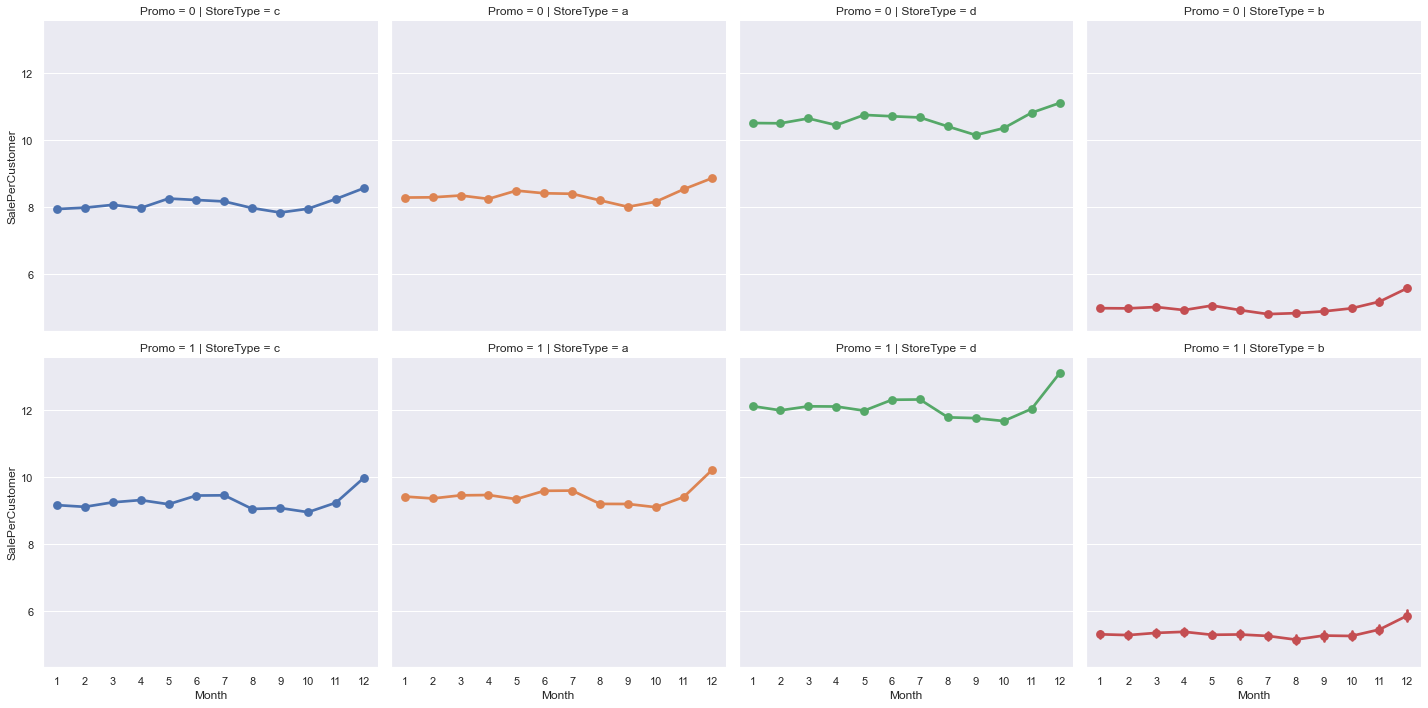

In [19]:
# ploting the montly data of the Sale per Customers when there is a promo and when there isn't one
sns.catplot(y='SalePerCustomer', x='Month', data=dfTrainStore, kind='point',
            col='StoreType', row='Promo', hue='StoreType')

- When there is a promo the average money spent per customer also increases
- StoreType b has the lowest sales per customer i.e the store sells low cost items
- sStoreType d has the highest sales per customer i.e the store sells high cost items

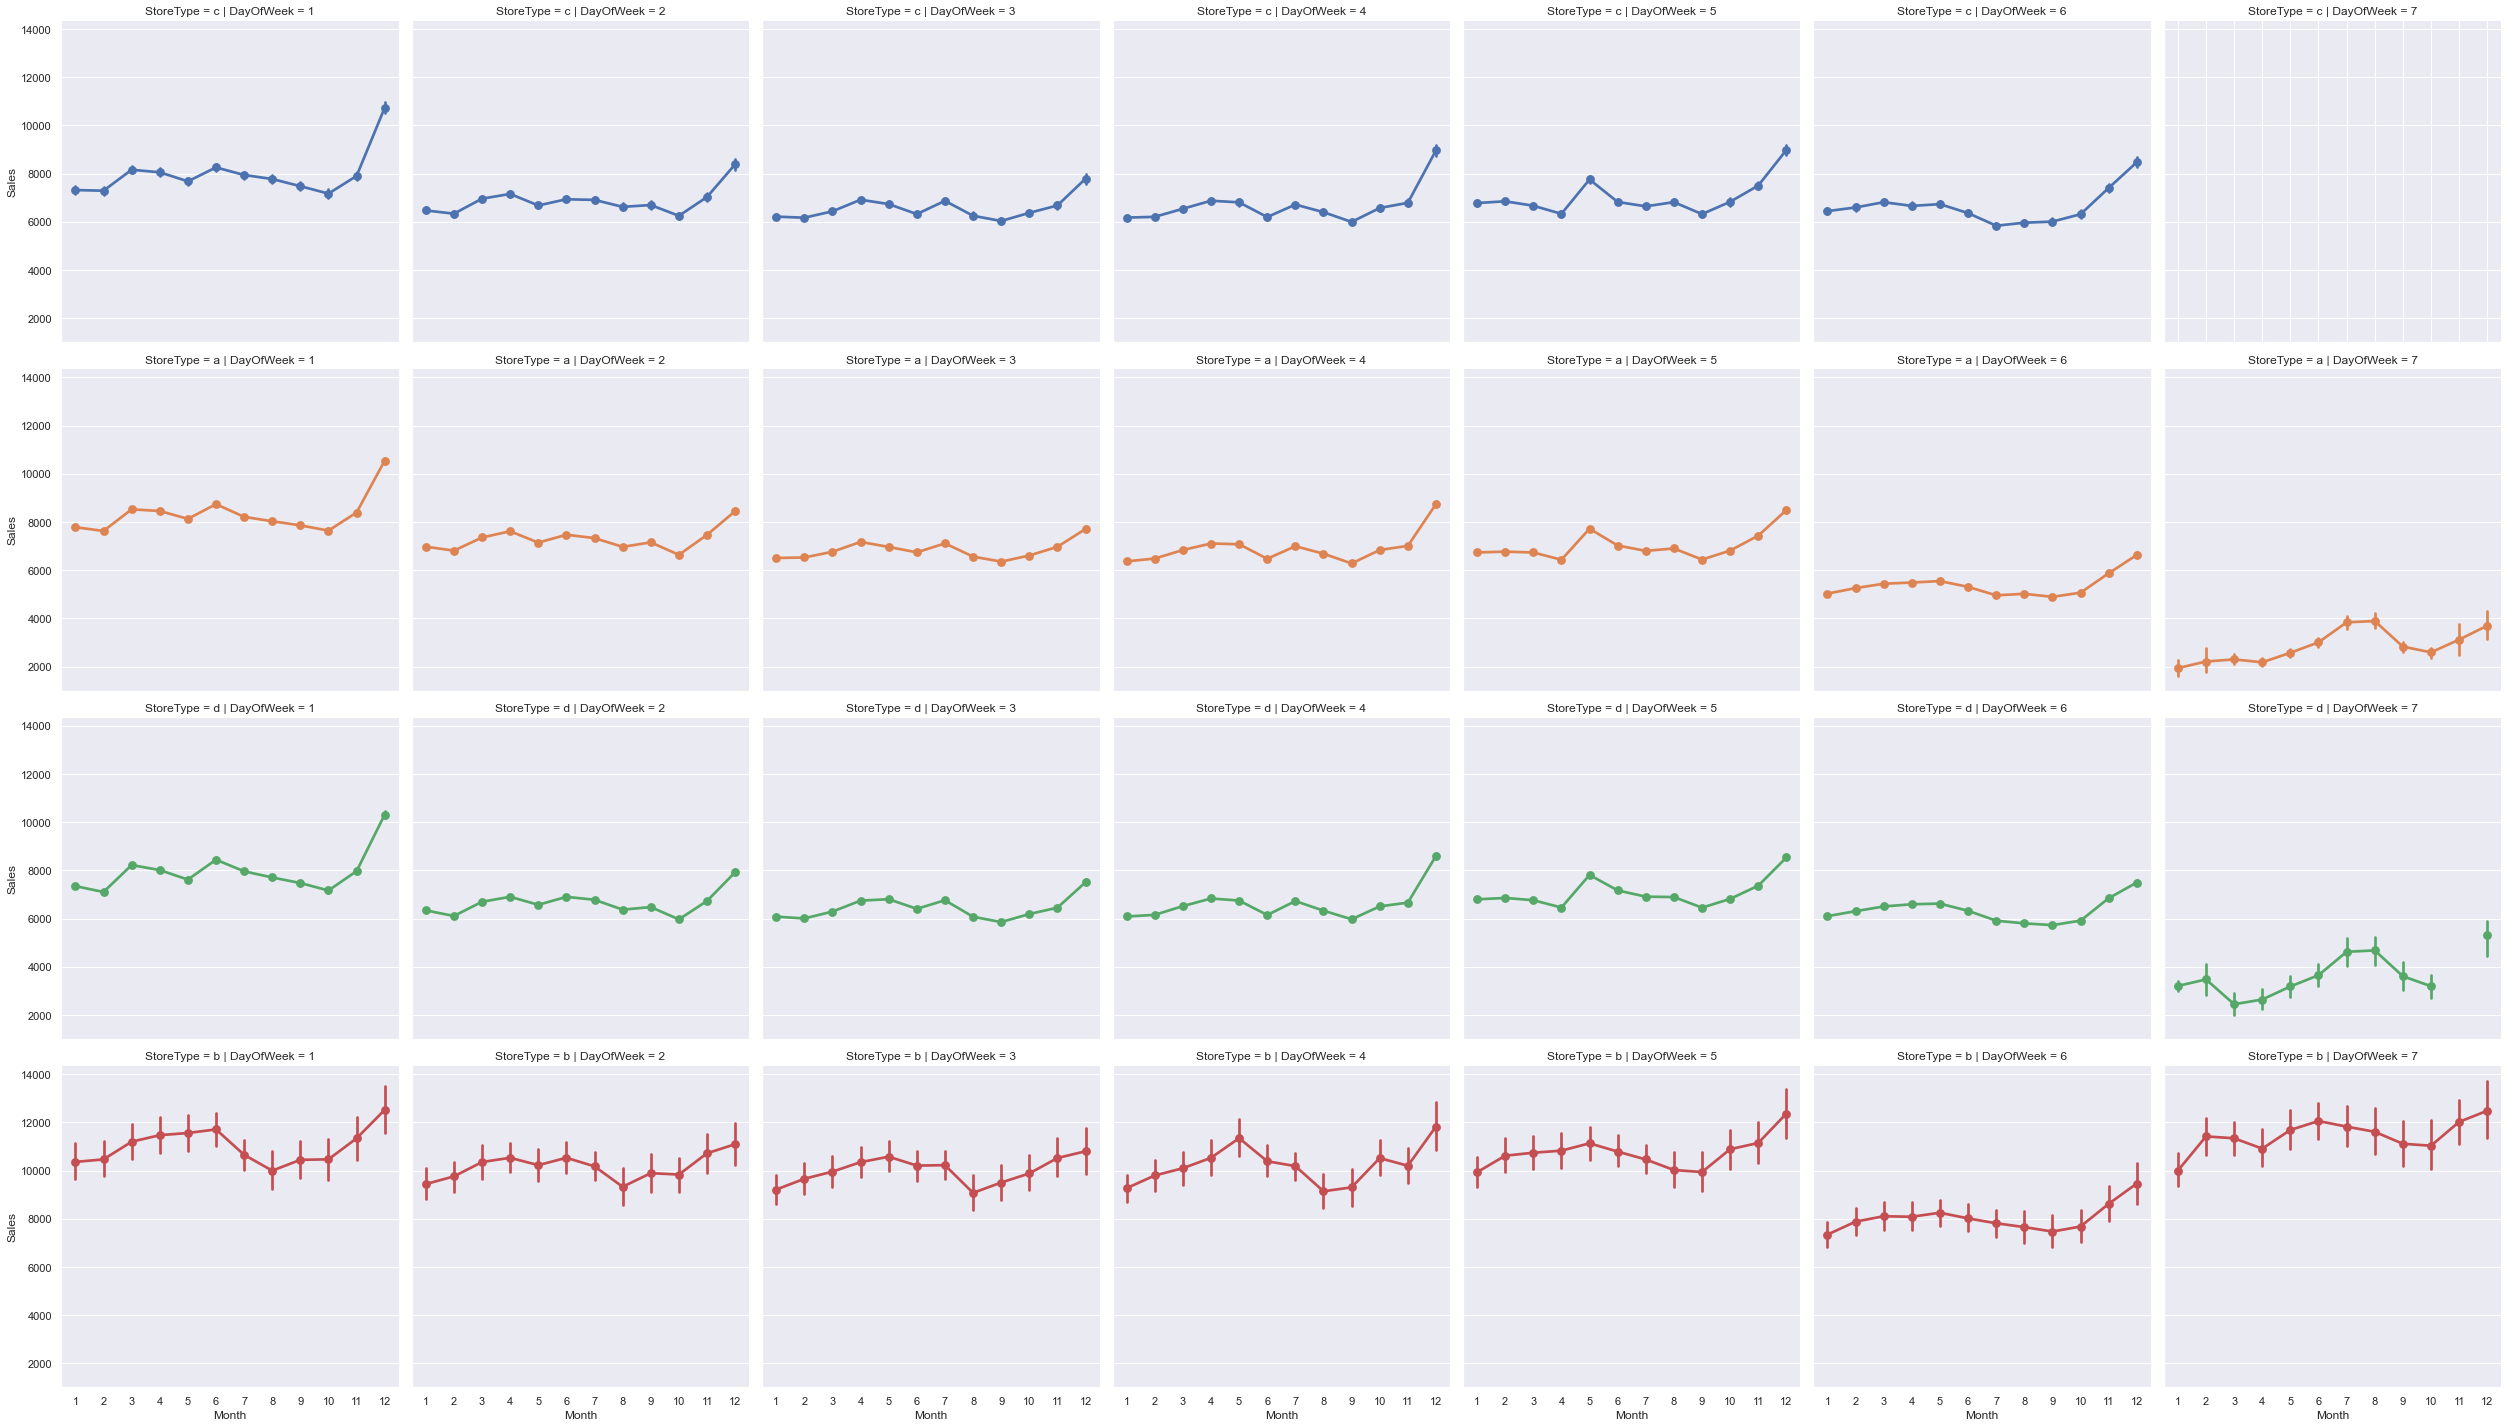

In [20]:
# ploting the daily data of the Sales for each type of Store Type
sns.catplot(x='Month', y='Sales', data=dfTrainStore, kind='point', 
            col='DayOfWeek', hue='StoreType', row='StoreType')

(Double click to zoom)
- Store Type C is closed on sundays all year Long
- Store Type D is closed on sundays for only two months October and November

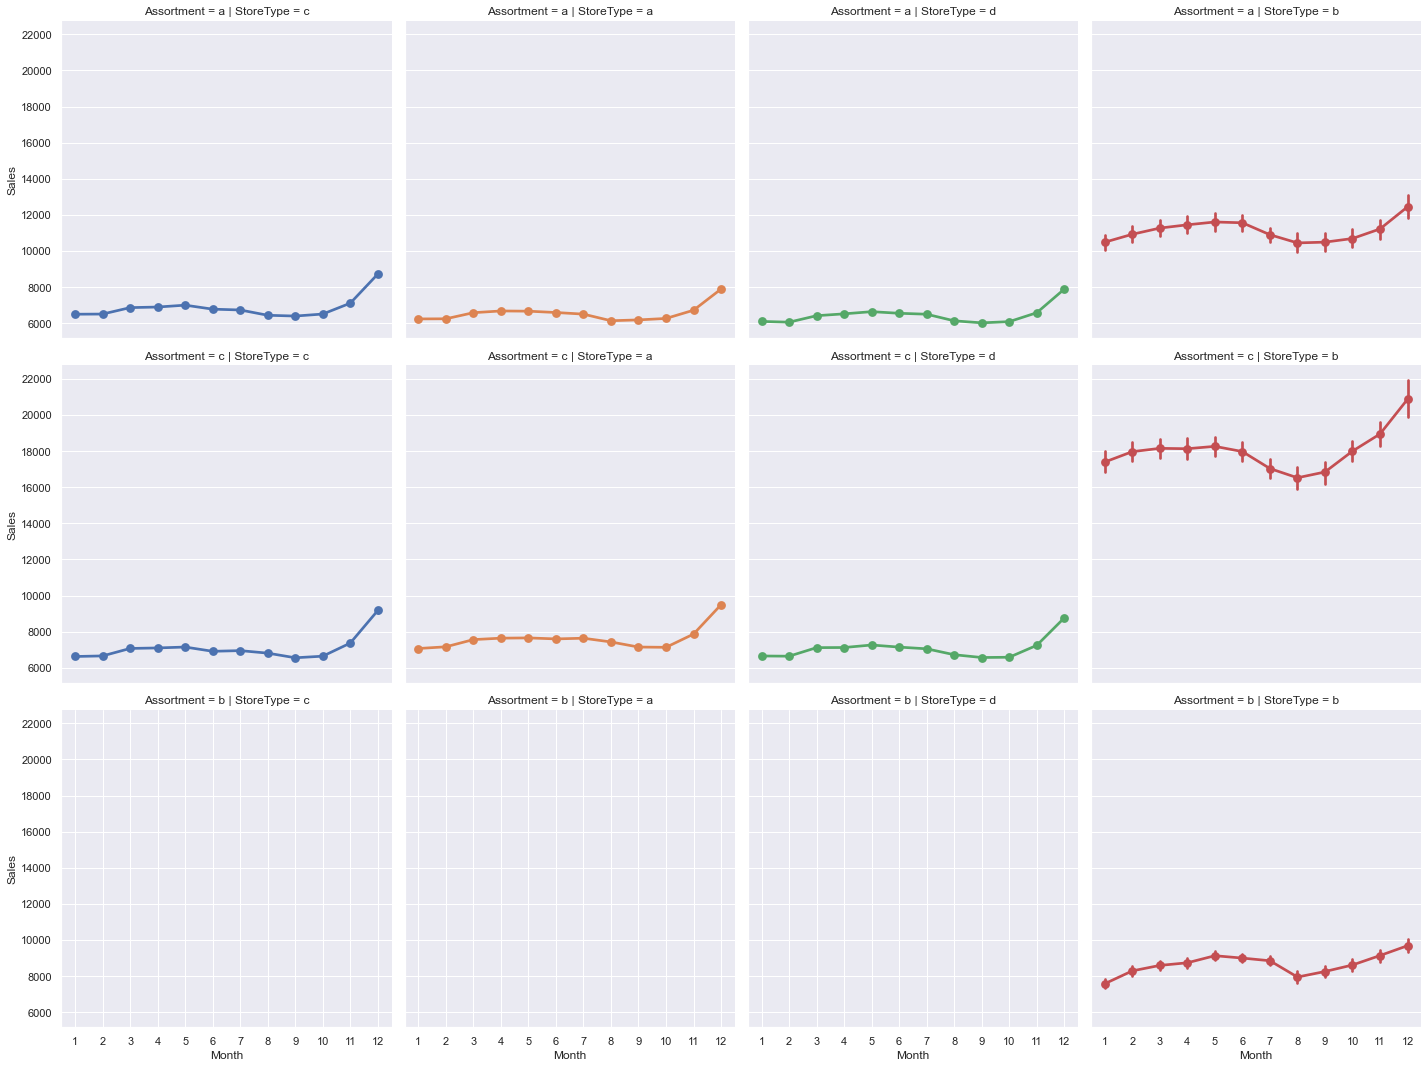

In [21]:
# How assorment type affects sales 
sns.catplot(x='Month', y='Sales', data=dfTrainStore, kind='point',
            col='StoreType', hue='StoreType', row='Assortment')


- The assortment c slightly increases the number of sales in the store types a, c and d in comparison to assortment a
- However assortment c offers a significant increase in store type b than assortment a and b

### Correlation Analysis


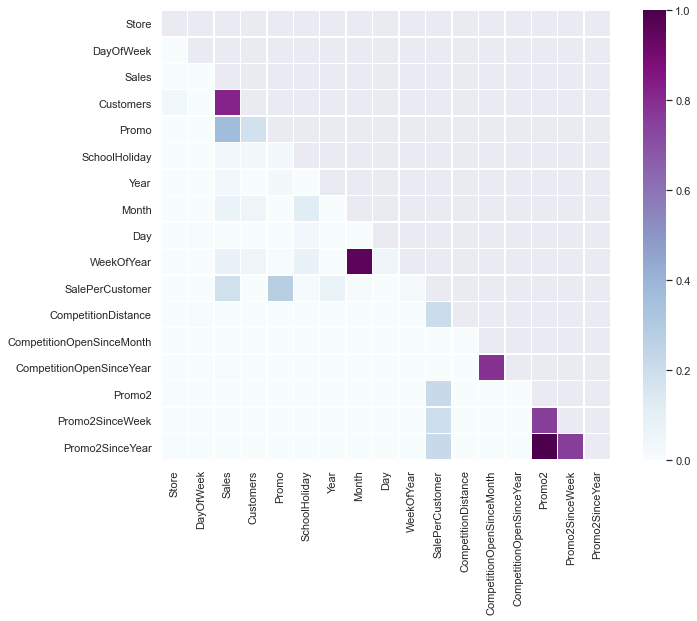

In [25]:
# get the correlation matrix
# dropping the open column
corr = dfTrainStore.drop('Open', axis=1).corr()

# create a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# plot the correlation heatmap
sns.heatmap(corr, vmin=0, vmax=1, square=True, cmap="BuPu",
           linewidths=.5, mask=mask)

The Customer and Sales columns are highly coorelated as expected

### Checking for Seasonality

In [28]:
# Get the Sales data
timeSeries = dfTrain['Sales']
timeSeries.head()

Date
2015-07-31     5263
2015-07-31     6064
2015-07-31     8314
2015-07-31    13995
2015-07-31     4822
Name: Sales, dtype: int64

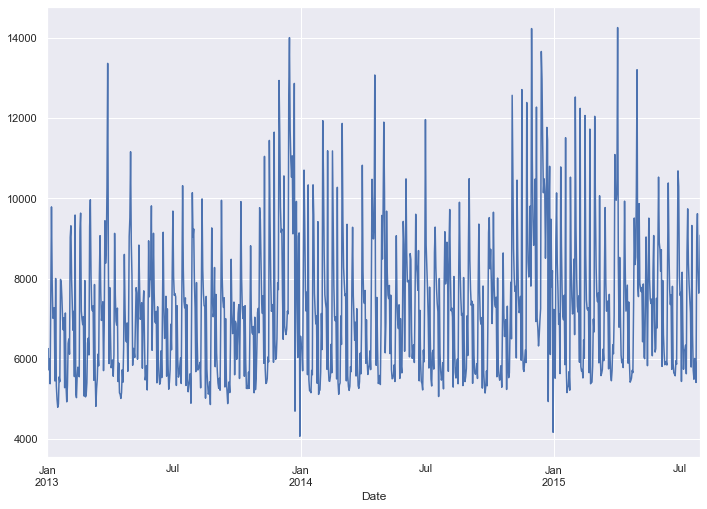

In [29]:
# plotting the mean sales values per day
timeSeriesDay = timeSeries.resample('D').mean()
timeSeriesDay.plot()

From the time series graph above we can see Just before January and in the middle of  January and July (probably around April)

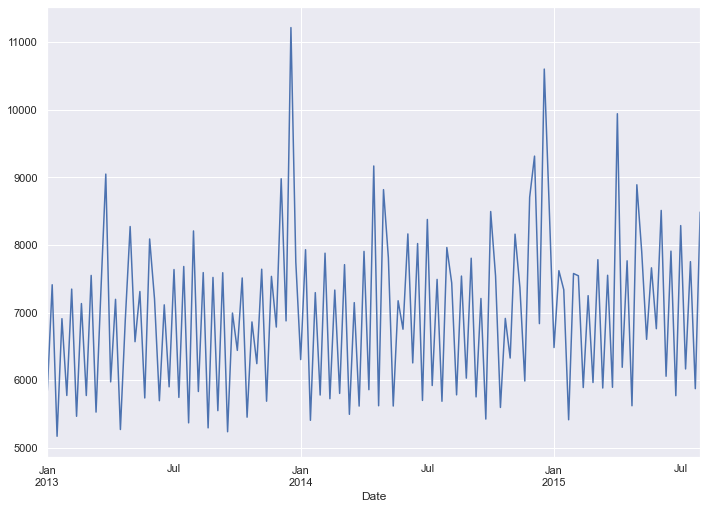

In [30]:
# plotting the mean sales values per week
timeSeriesWeek = timeSeries.resample('W').mean()
timeSeriesWeek.plot()

As we go from days to weeks the spikes mentioned above are more clear

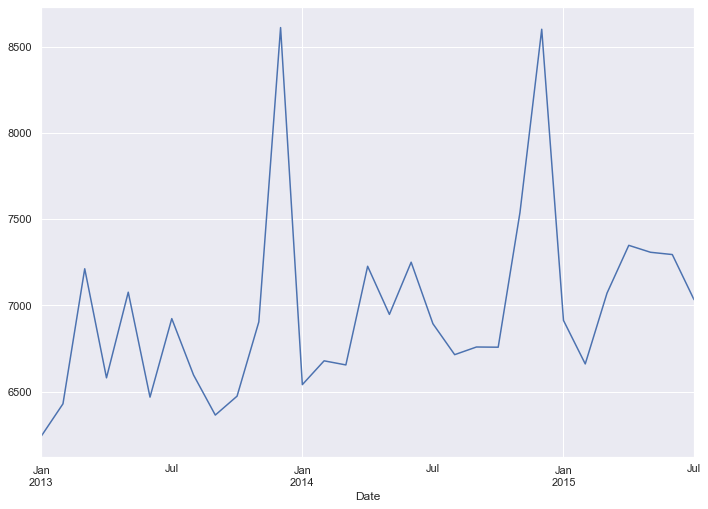

In [31]:
# plotting the mean sales values per Month
timeSeriesMonth = timeSeries.resample('M').mean()
timeSeriesMonth.plot()

The monthly data shows that the December spikes are the most apparent..

### Competitor Distance

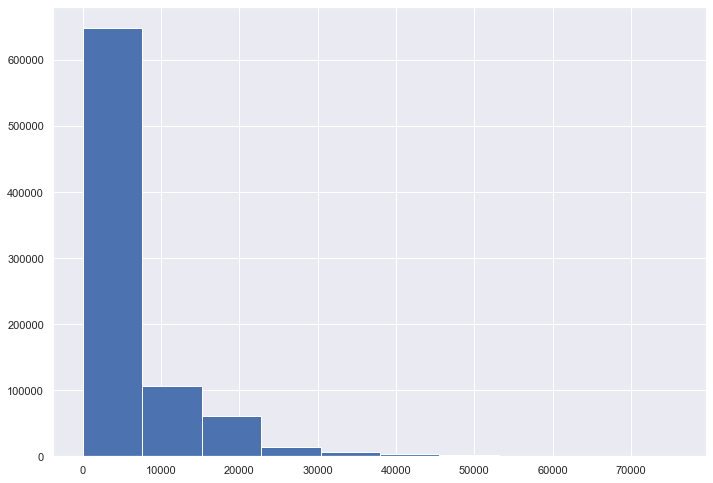

In [34]:
dfTrainStore.CompetitionDistance.hist()

In [36]:
# divide the data into distance ranges
distanceGroups = [dfTrainStore.CompetitionDistance.between(1, 99), dfTrainStore.CompetitionDistance.between(100, 999),
                  dfTrainStore.CompetitionDistance.between(1000, 9999), dfTrainStore.CompetitionDistance.between(10000, 99999)]
values = [1, 2, 3, 4]

dfTrainStore['DistanceGroup'] = np.select(distanceGroups, values, 0)
dfTrainStore.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DistanceGroup
0,1,5,5263,555,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3
1,1,4,5020,546,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3
2,1,3,4782,523,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3
3,1,2,5011,560,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3
4,1,1,6102,612,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3


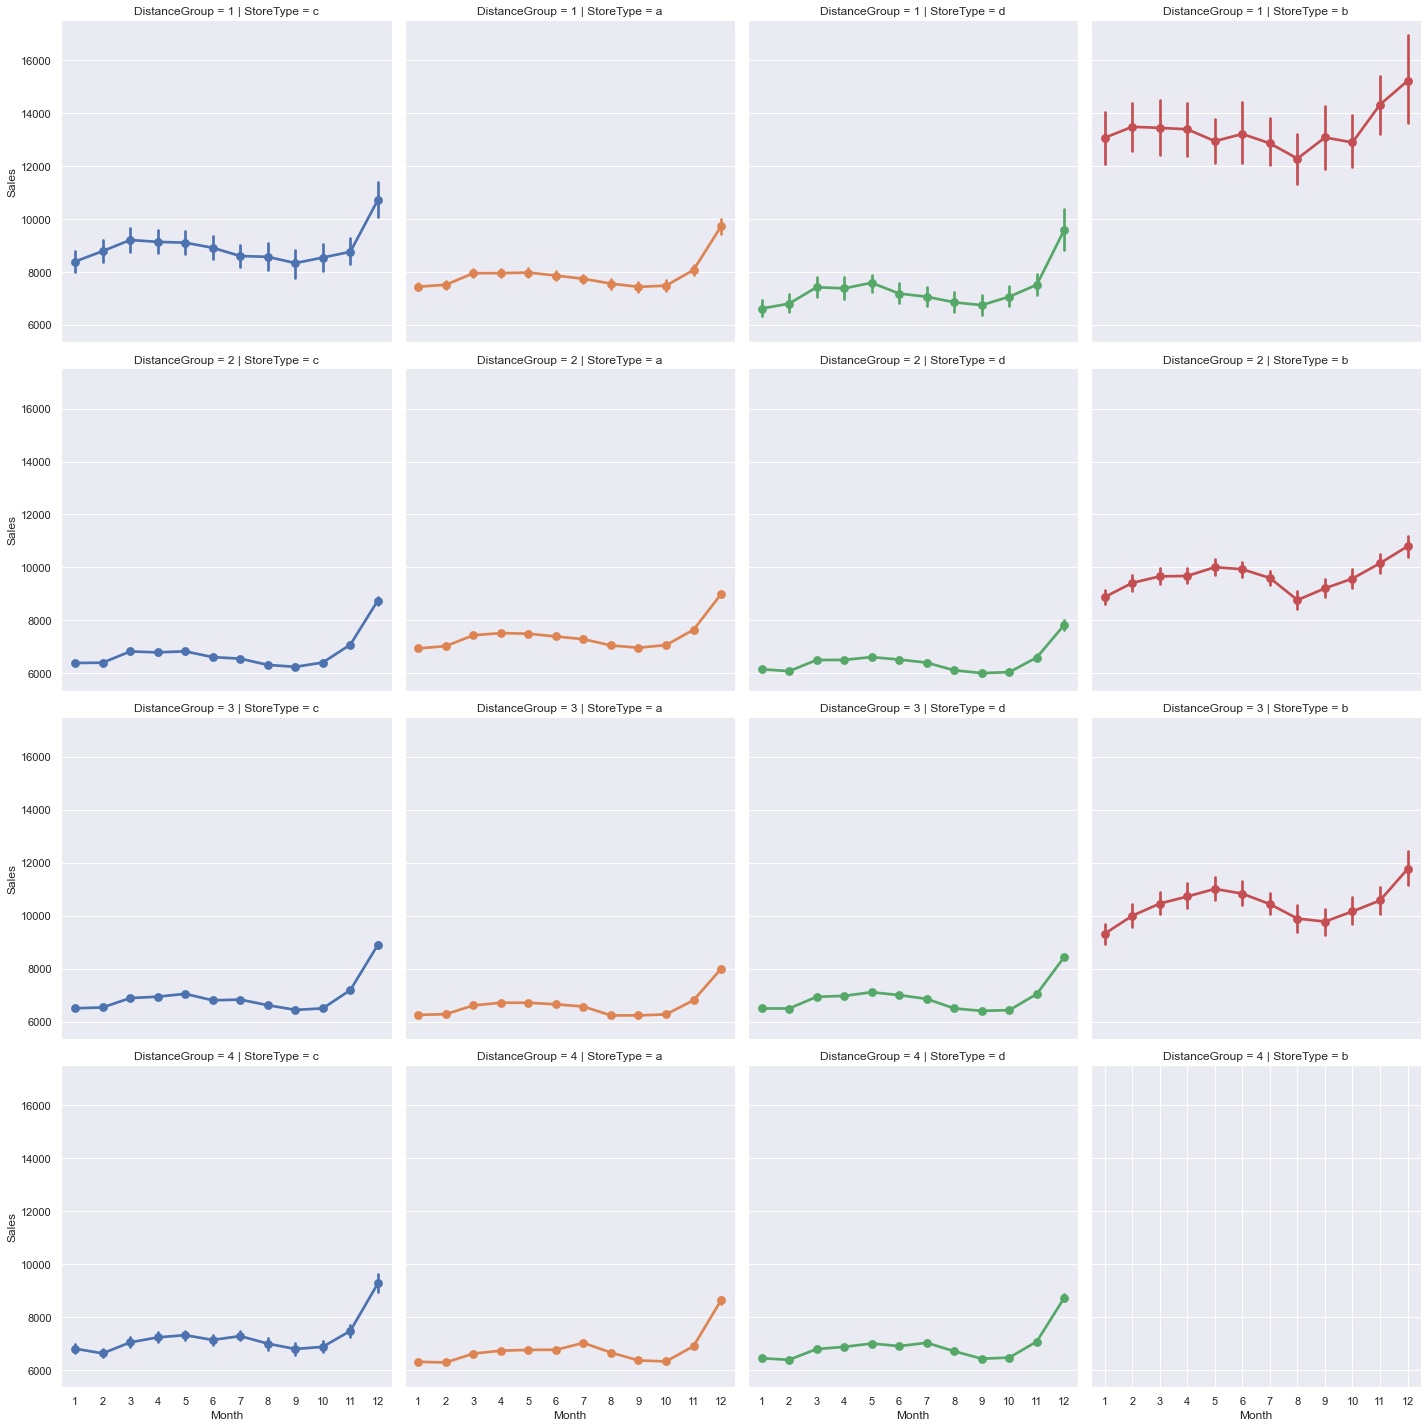

In [39]:
# plotting the monthly sales data for each of the distancegroups defined above
sns.catplot(y='Sales', x='Month', kind='point', hue='StoreType',
            col='StoreType', row='DistanceGroup', data=dfTrainStore)

In [40]:
# Getting the unique values for each month the competition has been open
dfTrainStore.CompetitionOpenSinceMonth.unique()

array([ 9., 11., 12.,  4., 10.,  8.,  0.,  3.,  6.,  5.,  1.,  2.,  7.])

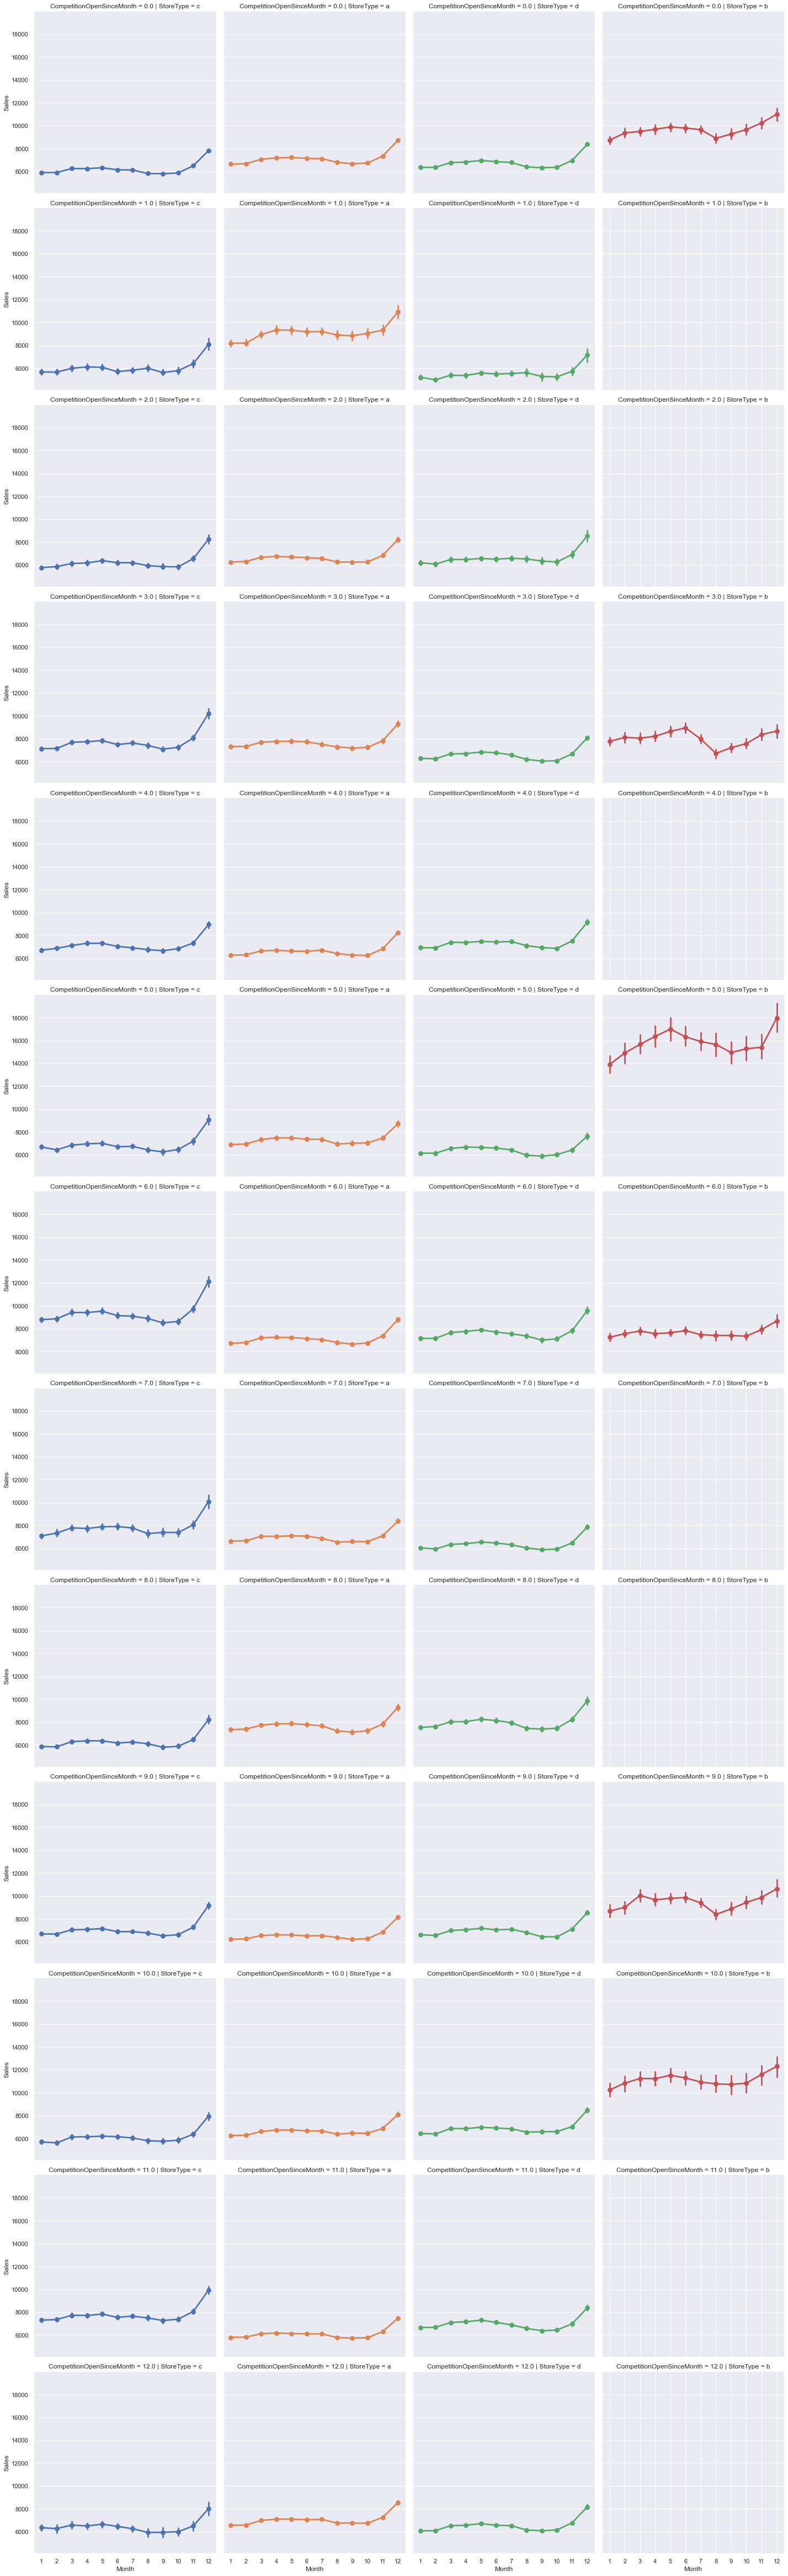

In [41]:
# plotting the monthly sales data for each of the months that the competition has been opened
sns.catplot(y='Sales', x='Month', kind='point', hue='StoreType',
            col='StoreType', row='CompetitionOpenSinceMonth', data=dfTrainStore)